<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Downloading-and-preprocessing" data-toc-modified-id="Downloading-and-preprocessing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Downloading and preprocessing</a></span></li><li><span><a href="#Prophet" data-toc-modified-id="Prophet-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Prophet</a></span></li><li><span><a href="#Evaluate" data-toc-modified-id="Evaluate-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Evaluate</a></span></li><li><span><a href="#Predict-into-the-future" data-toc-modified-id="Predict-into-the-future-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Predict into the future</a></span></li></ul></div>

## Imports

Сначала установить эти библиотеки. Прм дальнейших запусках можно закомментировать строки, поставив перед ними # (чтобы не запускать впустую).

In [1]:
!pip install numpy --upgrade
!pip install prophet
!pip install --upgrade pandas
!pip install bottleneck --upgrade
!pip install --upgrade seaborn

In [2]:
import pandas as pd
import numpy as np
from pandas.api.types import CategoricalDtype
from prophet import Prophet
from datetime import date
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

import requests
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import itertools
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

from tqdm import notebook
from tqdm.notebook import tqdm
tqdm.pandas()

E:\Temp\ipykernel_17360\891287710.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
param_grid = {  
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_range': [0.8, 0.95]
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

## Downloading and preprocessing

Берём сегодняшнюю дату (на момент запуска), скачиваем таблицу курса тенге с сайта ЦБ - с 01.01.2000 до сегодняшнего числа.

In [4]:
today = date.today()
d = today.strftime("%d.%m.%Y")

In [5]:
BASE_URL = 'http://cbr.ru/currency_base/dynamics/?UniDbQuery.Posted=True&UniDbQuery.so=1&UniDbQuery.mode=1\
&UniDbQuery.date_req1=&UniDbQuery.date_req2=&UniDbQuery.VAL_NM_RQ=R01335&UniDbQuery.From=01.01.2014&UniDbQuery.To='

data = requests.get(BASE_URL + d).text
bs = BeautifulSoup(data, 'html.parser')
tables = bs.find_all('table')

df = pd.read_html(str(tables))[0]

Выводим и последовательно очищаем данные/подводим под нужный формат.

In [6]:
df.head()

,0,1,2
0,Казахстанский тенге,Казахстанский тенге,Казахстанский тенге
1,Дата ▼,Единиц,Курс
2,15.02.2024,100,204093
3,14.02.2024,100,204167
4,13.02.2024,100,203703


In [7]:
df = df.iloc[2:].reset_index(drop=True)
df.head()

,0,1,2
0,15.02.2024,100,204093
1,14.02.2024,100,204167
2,13.02.2024,100,203703
3,10.02.2024,100,201826
4,09.02.2024,100,201832


In [8]:
df = df[::-1].reset_index(drop=True)
df

,0,1,2
0,01.01.2014,100,211760
1,10.01.2014,100,214573
2,11.01.2014,100,214836
3,14.01.2014,100,214101
4,15.01.2014,100,214789
...,...,...,...
2489,09.02.2024,100,201832
2490,10.02.2024,100,201826
2491,13.02.2024,100,203703
2492,14.02.2024,100,204167


In [9]:
df.drop(1, axis=1, inplace=True)
cols = {0: 'date', 2: 'rate'}
df.rename(columns=cols, inplace=True)

In [10]:
display(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2494 entries, 0 to 2493
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    2494 non-null   object
 1   rate    2494 non-null   object
dtypes: object(2)
memory usage: 39.1+ KB


None

,date,rate
0,01.01.2014,211760
1,10.01.2014,214573
2,11.01.2014,214836
3,14.01.2014,214101
4,15.01.2014,214789


In [11]:
df['date'] = pd.to_datetime(df['date'], dayfirst=True)
df['rate'] = df['rate'].astype('int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2494 entries, 0 to 2493
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2494 non-null   datetime64[ns]
 1   rate    2494 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 39.1 KB


In [12]:
df['rate_true'] = df['rate'] / 10000
df.tail()

,date,rate,rate_true
2489,2024-02-09,201832,20.1832
2490,2024-02-10,201826,20.1826
2491,2024-02-13,203703,20.3703
2492,2024-02-14,204167,20.4167
2493,2024-02-15,204093,20.4093


Делаем обратное соотношение (не тенге к рублю, а рубля к тенге)

In [13]:
df.drop('rate', axis=1, inplace=True)
df['rate_reverse'] = 100 / df['rate_true']
display(df.head())
df.tail()

,date,rate_true,rate_reverse
0,2014-01-01,21.1760,4.722327
1,2014-01-10,21.4573,4.660419
2,2014-01-11,21.4836,4.654713
3,2014-01-14,21.4101,4.670693
4,2014-01-15,21.4789,4.655732


,date,rate_true,rate_reverse
2489,2024-02-09,20.1832,4.954616
2490,2024-02-10,20.1826,4.954763
2491,2024-02-13,20.3703,4.909108
2492,2024-02-14,20.4167,4.897951
2493,2024-02-15,20.4093,4.899727


In [14]:
df.drop('rate_true', axis=1, inplace=True)
cols = {'rate_reverse': 'rate'}
df.rename(columns=cols, inplace=True)
df.sample(5)

,date,rate
2255,2023-03-02,5.924416
449,2015-10-29,4.277361
2316,2023-06-01,5.519891
566,2016-04-23,5.057862
2283,2023-04-12,5.406311


Смотрим график курса по дате и распределение значений.

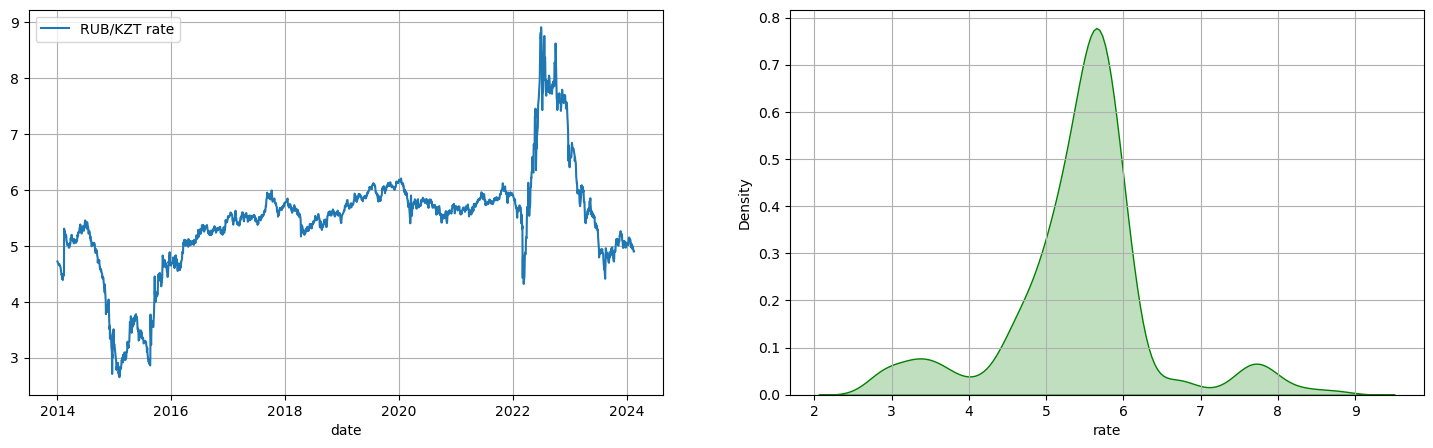

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(18,5))

axes[0].plot(df.date, df.rate, label='RUB/KZT rate')
axes[0].set_xlabel('date')
axes[0].legend(loc='best')
axes[0].grid(True)

sns.kdeplot(df['rate'], ax=axes[1], color='green', fill=True)
axes[1].grid(True)
plt.show()

Это создание вспомогательных признаков для прогноза, можно не думать над этим.

In [16]:
def create_features(data_full, col_datetime):
    data = data_full.copy()
    data['weekday'] = data[col_datetime].dt.day_name().astype(cat_type)
    data['quarter'] = data[col_datetime].dt.quarter
    data['month'] = data[col_datetime].dt.month
    data['year'] = data[col_datetime].dt.year
    data['date_offset'] = (data[col_datetime].dt.month * 100 + data[col_datetime].dt.day - 320) % 1300
    data['season'] = pd.cut(data['date_offset'], [0, 300, 602, 900, 1300], labels=['Spring', 'Summer', 'Fall', 'Winter'])
    return data

cat_type = CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                           ordered=True)

Смотрим образец данных.

In [17]:
df_features = create_features(df, 'date')
df_features.sample(10)

,date,rate,weekday,quarter,month,year,date_offset,season
601,2016-06-17,5.135210,Friday,2,6,2016,297,Spring
1880,2021-08-21,5.747391,Saturday,3,8,2021,501,Summer
984,2017-12-26,5.727344,Tuesday,4,12,2017,906,Winter
1694,2020-11-19,5.633581,Thursday,4,11,2020,799,Fall
1660,2020-10-01,5.494656,Thursday,4,10,2020,681,Fall
899,2017-08-26,5.623886,Saturday,3,8,2017,506,Summer
2132,2022-08-31,7.754162,Wednesday,3,8,2022,511,Summer
1510,2020-02-18,5.954508,Tuesday,1,2,2020,1198,Winter
1990,2022-02-03,5.673662,Thursday,1,2,2022,1183,Winter
577,2016-05-13,5.073541,Friday,2,5,2016,193,Spring


Исследуем на выбросы и нехватку данных...

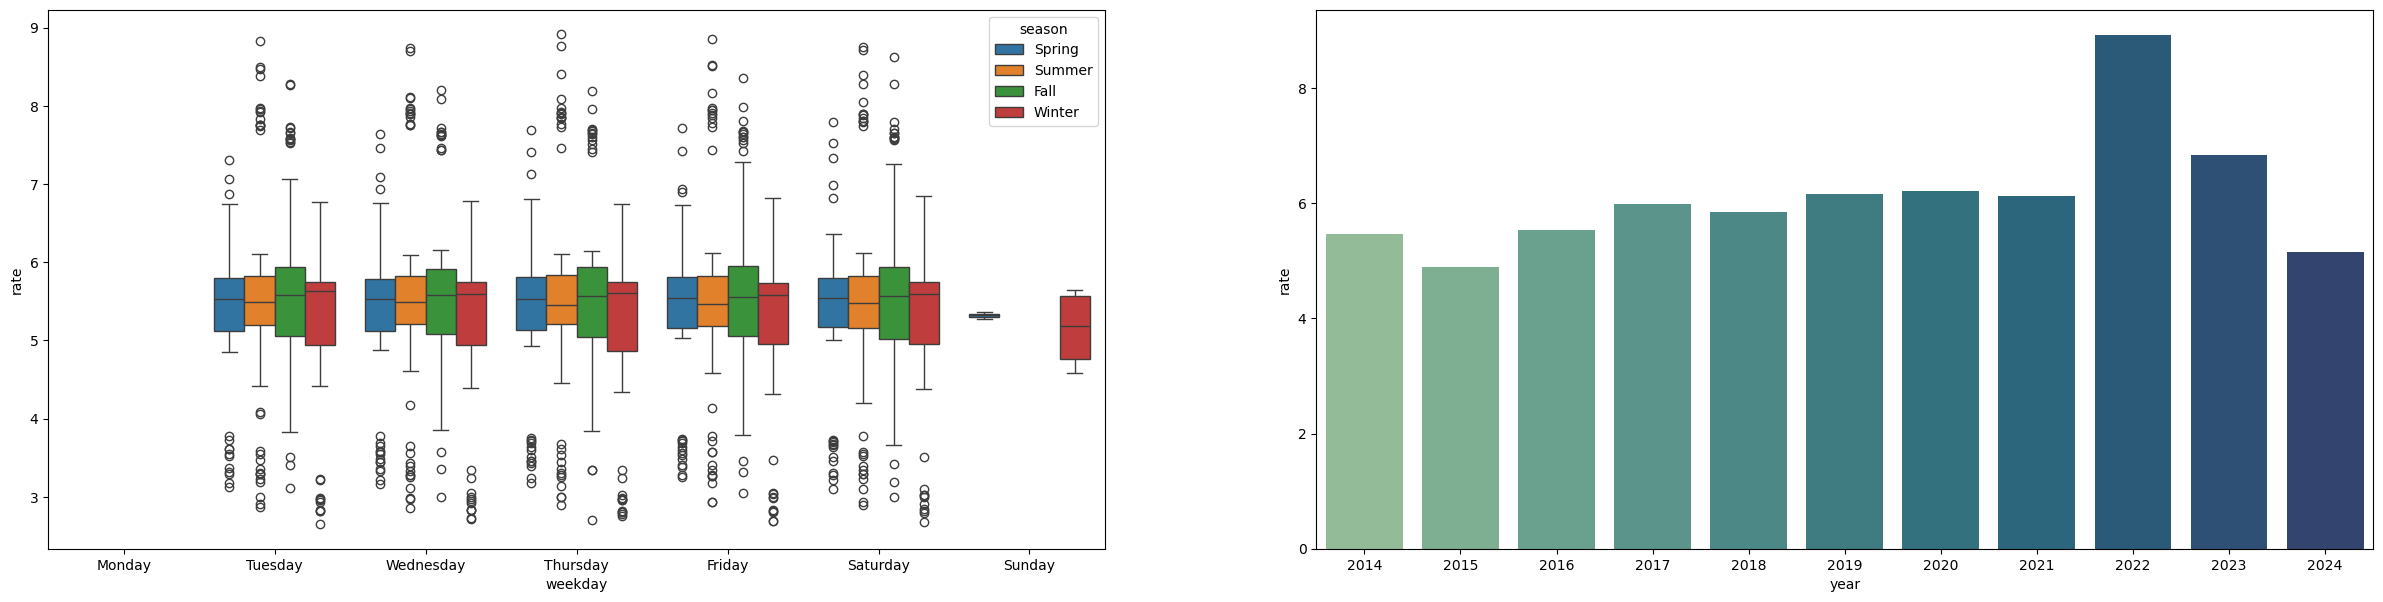

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(30,7))

sns.boxplot(data=df_features, x='weekday', y='rate', hue='season', ax=axes[0], linewidth=1)
axes[0].set_xlabel('weekday')
axes[0].set_ylabel('rate')

yearAgg = pd.DataFrame(df_features.groupby('year')['rate'].max()).reset_index().sort_values('rate')
sns.barplot(data=yearAgg, x='year', y='rate', palette='crest')
plt.show()

In [19]:
df_features[df_features.weekday == 'Monday']

,date,rate,weekday,quarter,month,year,date_offset,season


In [20]:
df_features[df_features.weekday == 'Sunday']

,date,rate,weekday,quarter,month,year,date_offset,season
525,2016-02-21,4.583014,Sunday,1,2,2016,1201,Winter
1065,2018-04-29,5.275764,Sunday,2,4,2018,109,Spring
1092,2018-06-10,5.364433,Sunday,2,6,2018,290,Spring
1235,2018-12-30,5.538018,Sunday,4,12,2018,910,Winter
1756,2021-02-21,5.642354,Sunday,1,2,2021,1201,Winter
2012,2022-03-06,4.822880,Sunday,1,3,2022,1286,Winter


Удаляем данные за понедельники и воскресенья, т.к. их в таблице мало (ЦБ не публикует?), чтобы они не создавали помехи.

In [21]:
drop_idx = df_features[(df_features.weekday == 'Monday') & (df_features.weekday == 'Sunday')].index
df = df[~df.index.isin(drop_idx)]
df = df.reset_index(drop=True)

## Prophet

Разбиваем на обучающую и тестовую выборки, проверяем график.

In [22]:
df.columns = ['ds', 'y']
SIZE = int(df.shape[0] * 0.1)
train_df = df[:-SIZE]
test_df = df[-SIZE:]
print(train_df.shape, test_df.shape)

(2245, 2) (249, 2)


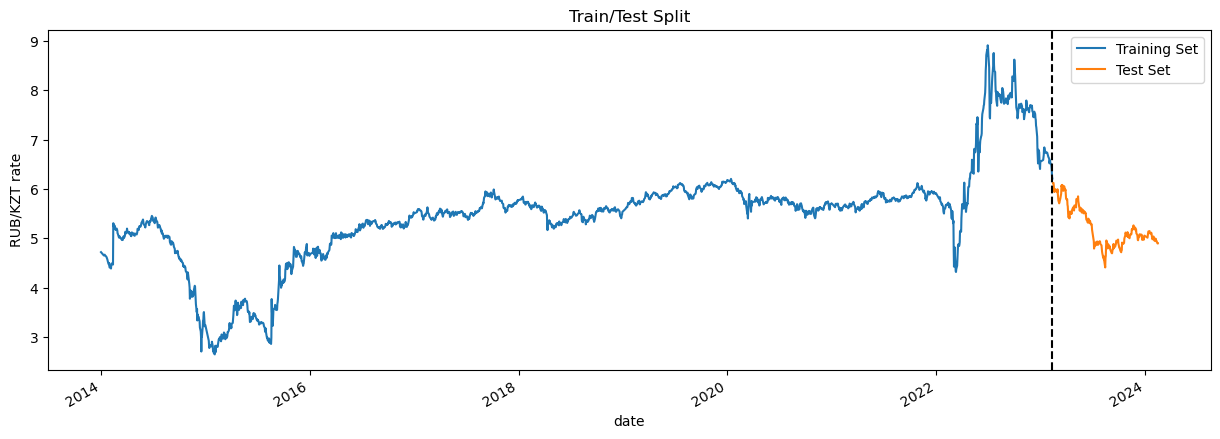

In [23]:
fig, ax = plt.subplots(figsize=(15,5))

train_df.set_index('ds').plot(ax=ax, label='Train', title='Train/Test Split')
test_df.set_index('ds').plot(ax=ax, label='Test')
ax.axvline(train_df['ds'][-1:].values, color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
ax.set_ylabel('RUB/KZT rate')
ax.set_xlabel('date')
plt.show()

Создаём модель Prophet, обучаем её на обучающей выборке и смотрим график прогноза.

In [24]:
for params in tqdm(all_params):
    m = Prophet(**params).fit(train_df)  # Fit model with given params
    df_cv = cross_validation(m, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = pd.Series(rmses)
print(tuning_results)

  0%|          | 0/36 [00:00<?, ?it/s]

15:16:45 - cmdstanpy - INFO - Chain [1] start processing
15:16:45 - cmdstanpy - INFO - Chain [1] done processing
15:16:53 - cmdstanpy - INFO - Chain [1] start processing
15:16:54 - cmdstanpy - INFO - Chain [1] done processing
15:17:02 - cmdstanpy - INFO - Chain [1] start processing
15:17:02 - cmdstanpy - INFO - Chain [1] done processing
15:17:11 - cmdstanpy - INFO - Chain [1] start processing
15:17:11 - cmdstanpy - INFO - Chain [1] done processing
15:17:20 - cmdstanpy - INFO - Chain [1] start processing
15:17:20 - cmdstanpy - INFO - Chain [1] done processing
15:17:29 - cmdstanpy - INFO - Chain [1] start processing
15:17:29 - cmdstanpy - INFO - Chain [1] done processing
15:17:37 - cmdstanpy - INFO - Chain [1] start processing
15:17:38 - cmdstanpy - INFO - Chain [1] done processing
15:17:54 - cmdstanpy - INFO - Chain [1] start processing
15:17:54 - cmdstanpy - INFO - Chain [1] done processing
15:18:13 - cmdstanpy - INFO - Chain [1] start processing
15:18:13 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                      0.01                      0.1         additive   
1                      0.01                      0.1         additive   
2                      0.01                      0.1   multiplicative   
3                      0.01                      0.1   multiplicative   
4                      0.01                      1.0         additive   
5                      0.01                      1.0         additive   
6                      0.01                      1.0   multiplicative   
7                      0.01                      1.0   multiplicative   
8                      0.01                     10.0         additive   
9                      0.01                     10.0         additive   
10                     0.01                     10.0   multiplicative   
11                     0.01                     10.0   multiplicative   
12                     0.10                      0.

In [25]:
best_rmse = tuning_results[tuning_results['rmse'] == tuning_results['rmse'].min()]
best_rmse

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,changepoint_range,rmse
29,0.5,1.0,additive,0.95,0.40771


In [26]:
best_rmse.drop('rmse', axis=1, inplace=True)
best_rmse.reset_index(drop=True, inplace=True)

In [27]:
params_dict = best_rmse.to_dict(orient='records')
best_params = params_dict[0]
best_params

{'changepoint_prior_scale': 0.5,
 'seasonality_prior_scale': 1.0,
 'seasonality_mode': 'additive',
 'changepoint_range': 0.95}

In [28]:
model = Prophet(**best_params).fit(train_df)

15:29:19 - cmdstanpy - INFO - Chain [1] start processing
15:29:20 - cmdstanpy - INFO - Chain [1] done processing


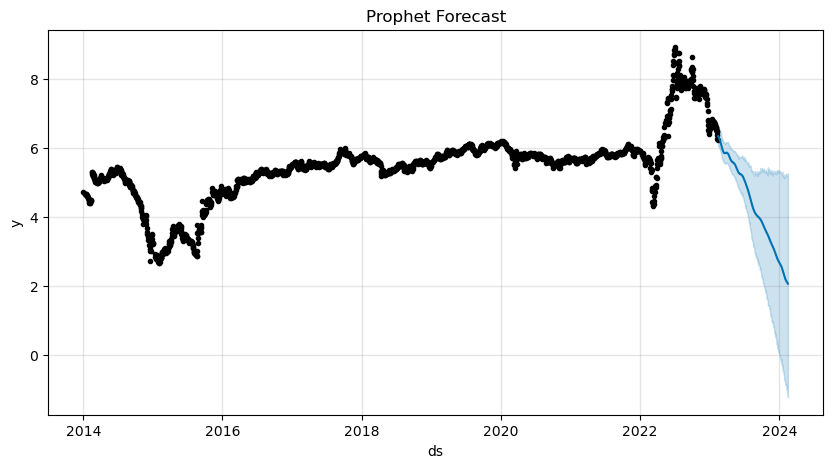

In [29]:
fig, ax = plt.subplots(figsize=(10, 5))

predict = model.predict(test_df)
fig = model.plot(predict, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

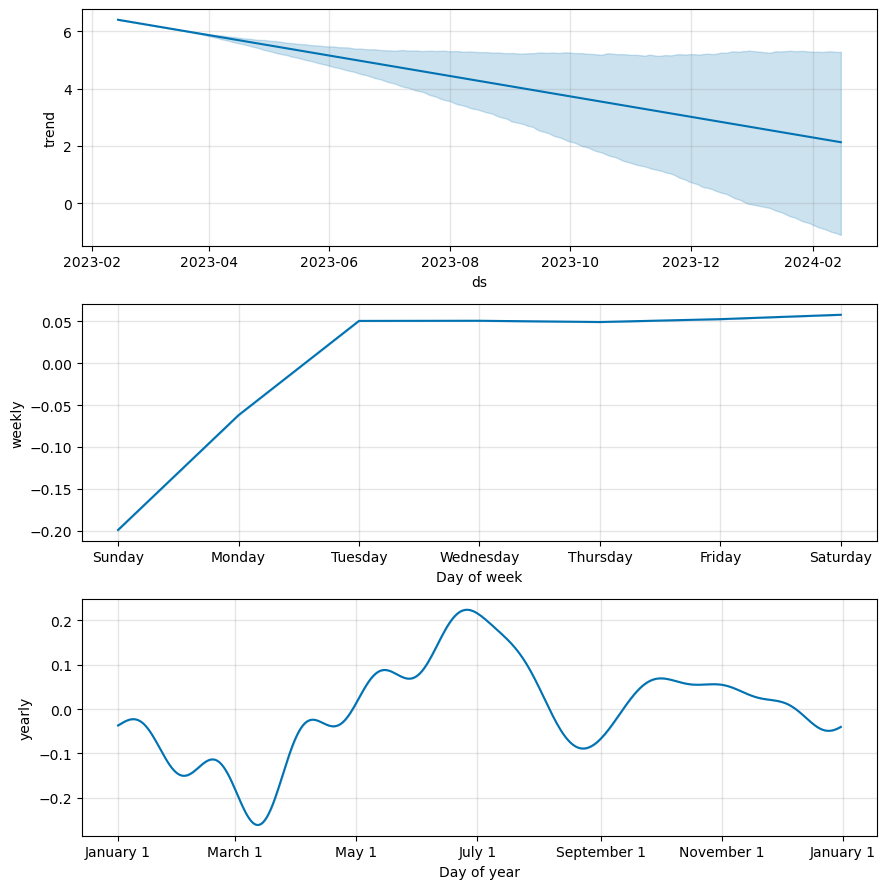

In [30]:
fig = model.plot_components(predict)
plt.show()

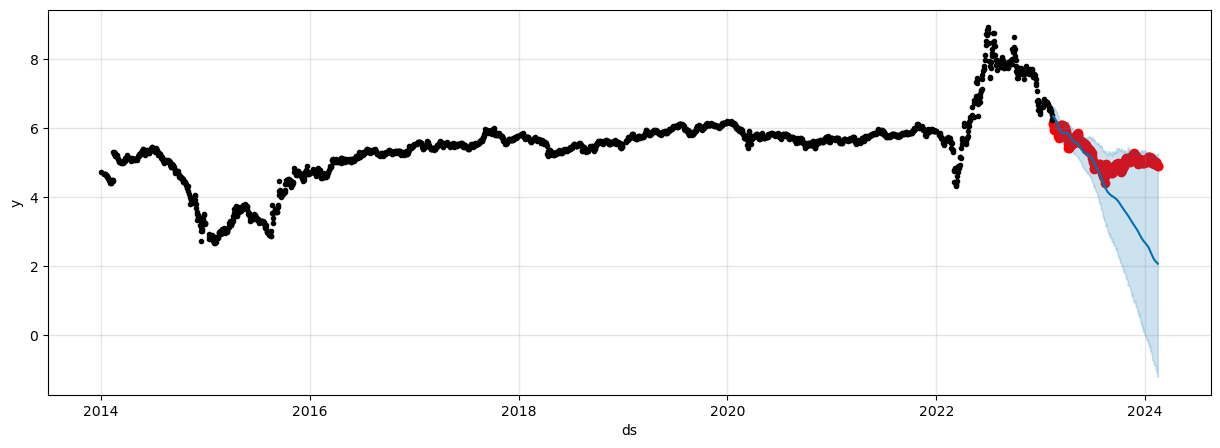

In [31]:
f, ax = plt.subplots(figsize=(15, 5))

ax.scatter(test_df.ds, test_df['y'], color='r')
fig = model.plot(predict, ax=ax)

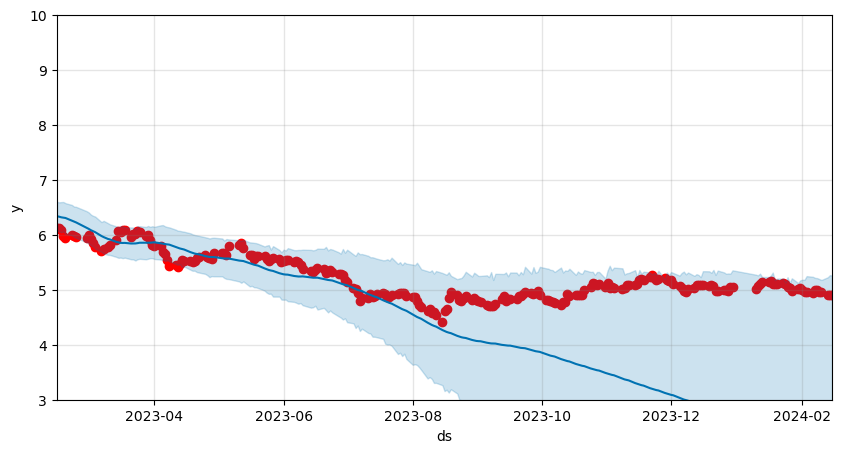

In [32]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(test_df.ds, test_df['y'], color='r')
fig = model.plot(predict, ax=ax)
ax.set_xbound(lower=test_df['ds'][:1].values[0], upper=test_df['ds'][-1:].values[0])
ax.set_ylim(3, 10)
plt.show()

## Evaluate

Вычисляем ошибки прогноза.

In [33]:
df_test_null = test_df.copy()
df_test_null['y'] = None

df_predict = pd.concat([test_df, df_test_null])
predict = model.predict(df_predict)

In [34]:
mean_absolute_error(y_true=test_df['y'],
                    y_pred=predict['yhat'][train_df.shape[1]:SIZE+2])

0.37650989861682627

In [35]:
mean_absolute_percentage_error(y_true=test_df['y'],
                               y_pred=predict['yhat'][train_df.shape[1]:SIZE+2])

0.0745605189123933

## Predict into the future

А теперь создаём новую модель, обучаем на всём наборе и прогнозируем на 14 дней вперёд.

In [36]:
df.head()

,ds,y
0,2014-01-01,4.722327
1,2014-01-10,4.660419
2,2014-01-11,4.654713
3,2014-01-14,4.670693
4,2014-01-15,4.655732


In [37]:
%%time
model_full = Prophet(**best_params)
model_full.fit(df)

15:29:56 - cmdstanpy - INFO - Chain [1] start processing
15:29:56 - cmdstanpy - INFO - Chain [1] done processing


Wall time: 747 ms


In [38]:
future = model_full.make_future_dataframe(periods=14, freq='D')
forecast = model_full.predict(future)

In [39]:
forecast['yhat'].head()

0    4.688616
1    4.757223
2    4.765279
3    4.768568
4    4.771391
Name: yhat, dtype: float64

Просто вывод в виде таблицы (курс теперь обратный, рубля к тенге)

In [40]:
forecast_display = forecast[['ds', 'yhat']].tail(20)
forecast_display

,ds,yhat
2488,2024-02-08,5.062977
2489,2024-02-09,5.073034
2490,2024-02-10,5.081906
2491,2024-02-13,5.092861
2492,2024-02-14,5.099463
2493,2024-02-15,5.099605
2494,2024-02-16,5.108316
2495,2024-02-17,5.114816
2496,2024-02-18,4.885668
2497,2024-02-19,5.082054


График всего датасета

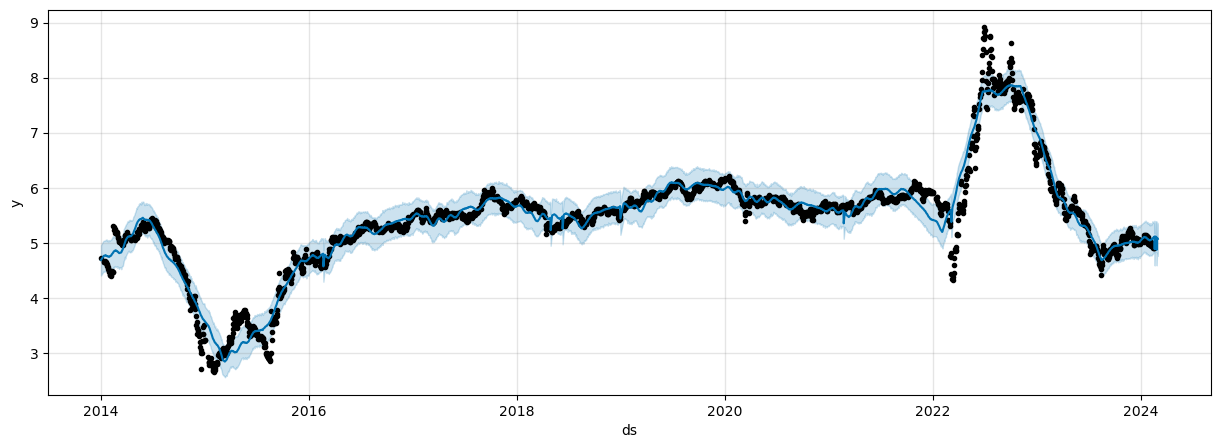

In [41]:
f, ax = plt.subplots(figsize=(15, 5))
fig = model_full.plot(forecast, ax=ax)

Компоненты временного ряда (тренд и две сезонности)

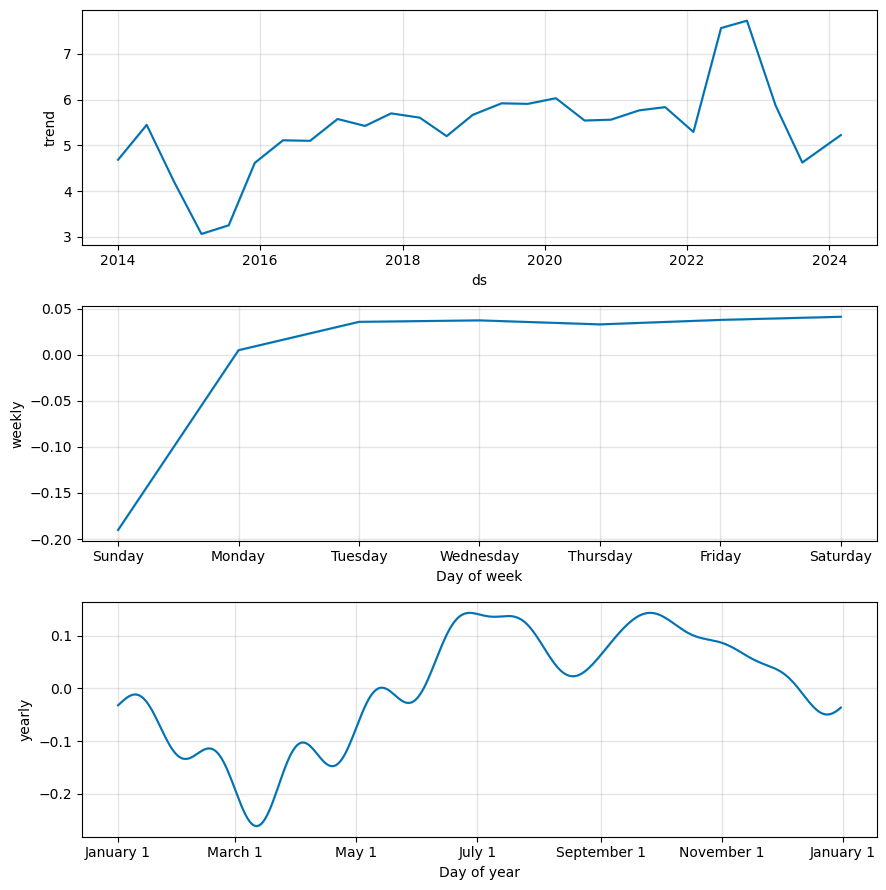

In [42]:
fig = model_full.plot_components(forecast)
plt.show()

График предсказанного + чуть-чуть существующего (точности в цифрах не будет! но можно попробовать отследить взлёты и падения по датам)

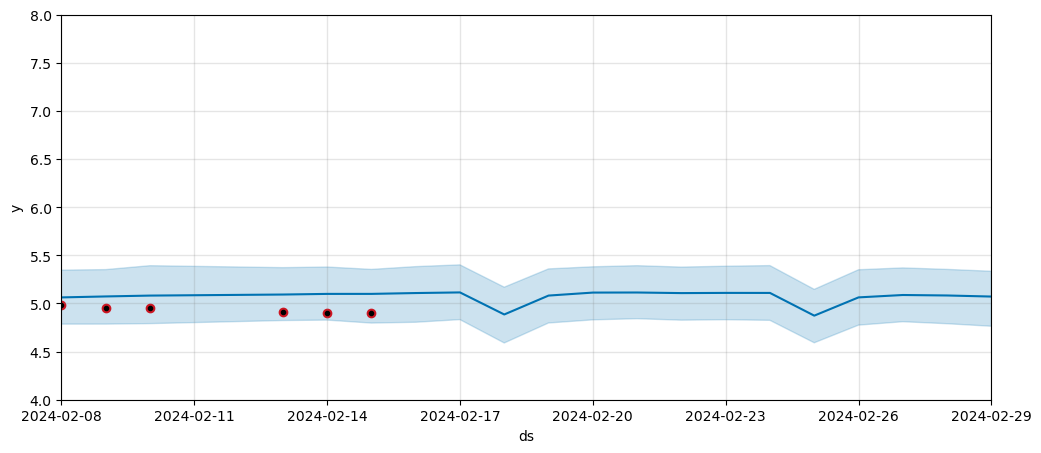

In [43]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.scatter(df.ds, df['y'], color='r')
fig = model_full.plot(forecast, ax=ax)
ax.set_xbound(lower=forecast['ds'][-20:].values[0], upper=forecast['ds'][-1:].values[0])
ax.set_ylim(4, 8)
plt.show()